## Creation of Borehole object

In [3]:
%matplotlib inline

from striplog import Striplog, Legend, Lexicon, Interval, Component, Position
import pyvista as pv, geopandas as gpd, pandas as pd, scipy, numpy as np
import matplotlib.pyplot as plt, omfvista as ov, omf
import sqlite3
from sqlite3 import Error

from utils import read_flat_files
from utils.db_tools import boreholes_dict_to_sqlite3_db, create_connection
from utils.strip_vista import build_strip_from_list as build_log, add_interval_list

In [167]:
class Borehole(omf.lineset.LineSetElement, Striplog):
    #-------------------------------Docstring--------------------------------------------
    """
        
    """
    
    #------------------------------ Properties -------------------------------------------
    def __init__ (self, geom=None, intv=None, name='', database = 'default.db'): #, *itv_list): 
        if geom is None :
            geom=omf.lineset.LineSetGeometry(vertices=[[0,0,0], [0,0,0]],segments=[[0,1]])
            print("Pay attention that a default geometry is actually used !")
        else:
            geom=self.build_geometry()
            
            
        if intv is None:
            lexicon=Lexicon.default()
            with open('test.las', 'r') as las3:
                default_intv=Striplog.from_las3(las3.read(), lexicon)
                intv = list(default_intv)
            print("Pay attention that default intervals are actually used !")
        else:
            #lexicon=
            print("intervals created")
            
        # instanciation with supers properties
        omf.lineset.LineSetElement.__init__(self, name=name, geometry=geom, subtype="borehole")
        Striplog.__init__(self, list_of_Intervals=intv)
        
        #self.uid=uuid #get a unique for identification of borehole in the project
        self.name = name
        self.__db = None
        self.dfs = None
        self.geometry=geom
        self.intervals=intv
        self.database = database
        
        try:
            self.read_db_bh()
        except:
            msg = f'Error: Unable to open database {self.database:s}'
            print(msg)
        print(f'\nBorehole {name:s} created')
        
    @property
    def database(self):
        return self.__db
    
    @database.setter
    def database(self, database):
        assert(isinstance(database, str))
        self.__db = database
        print(f"the default database has been changed to {self.__db} !")
    
    #----------------------------------------- Methods ------------------------------------------------------
    def read_db_bh(self):
        conn = create_connection(self.database)
        tables = ['Boreholes', 'Components', 'Intervals', 'Lexicon'] # table names in the database
        dfs = {}
        with conn:
            for i in tables:
                print(f"---{i:s} data--- ")
                sql_cmd = f"SELECT * FROM {i:s}" # WHERE Borehole=={self.name:s}" # to select the data of the table Boreholes
                print(sql_cmd)
                dfs.update({i:  pd.read_sql(sql_cmd, conn)})
        self.dfs = dfs
    
    def build_striplog(self, itv=None):
        
        
        return self.striplog
    
    def stripBH(self, legend="default", title=False): # must be integrated in plot() ever present in Striplog
        if legend=="default":
            try:
                file='../legend_GSDMA.csv'
                with open(file) as f:
                    legend = Legend.from_csv(filename=file)
            except FileNotFoundError:
                print(f"The default legend file ({file:s}) not found, please give another legend description file !")
            
        strip_bh=Striplog(build_log(self.name, self.dfs))
        
        fig, axs = plt.subplots(ncols=2, sharey=True)
        axs[0] = strip_bh.plot(ax=axs[0], legend=legend, ladder=True, aspect=2, alpha=0.7, lw=2, ticks=1) #alpha to highlight overlaps
        axs[1] = strip_bh.plot_tops(axs[1], field='lithology')
        axs[1].axis('off')
        if title==True:
            fig.suptitle(self.name, fontsize=20, x=0.3, y=1)
        
        fig.savefig(f"Striplog_{self.name:s}.png")
        plt.show()
        plt.close('all')
        
        
    def build_geometry(self, bh_itv=None):
        if bh_itv is None:
            bh_itv=bh.dfs['Intervals'].query("borehole=='{name:s}'".format(name=self.name))
            
        x, y=0.5, 0.5 # we must use Borehole x,y coordinates here !!!
        vert, vertices, segments =[],[], []

        for i, j in bh_itv.iterrows():
            if not bh_itv.loc[i, 'top'] in vert:
                vert.append(bh_itv.loc[i, 'top'])

            if not bh_itv.loc[i, 'base'] in vert:
                vert.append(bh_itv.loc[i, 'base'])

        for z in vert:
            vertices.append([x,y,z])

        vertices=np.array(vertices)

        for l in np.arange(1,len(vertices)):
            segments.append([l-1,l])

        segments=np.array(segments)
        self.geometry=omf.lineset.LineSetGeometry(vertices=vertices,segments=segments)
        print("Borehole geometry created successfully !")
        
        return self.geometry
        
    def store_in_db(self):
         print(f"---Borehole {self.name:s} has been stored in project database--- ")
        
    def triDim_plot(self):
        return ov.line_set_to_vtk(bh).plot()

In [169]:
bh = Borehole(geom=None, name='F25', database = '../project_database.db')

Pay attention that a default geometry is actually used !
Pay attention that default intervals are actually used !
the default database has been changed to ../project_database.db !
---Boreholes data--- 
SELECT * FROM Boreholes
---Components data--- 
SELECT * FROM Components
---Intervals data--- 
SELECT * FROM Intervals
---Lexicon data--- 
SELECT * FROM Lexicon

Borehole F25 created


In [191]:
print("borehole.dfs:",bh.dfs.keys())

borehole.dfs: dict_keys(['Boreholes', 'Components', 'Intervals', 'Lexicon'])


In [194]:
itv

,borehole,top,base,description
0,F10,0.0,1.5,remblais non-saturés
1,F10,1.5,4.0,remblais saturés
2,F10,4.0,6.0,alluvions
3,F11,0.0,1.5,remblais non-saturés
4,F11,1.5,4.0,remblais saturés
...,...,...,...,...
73,F24,1.5,4.0,remblais saturés
74,F24,4.0,6.0,alluvions
75,F25,0.0,1.5,remblais non-saturés
76,F25,1.5,4.0,remblais saturés


In [217]:
# build a Component object
#desc = "dark chalk of 20% of porosity"
#rock=Component()

#another way
#rock = Component({'colour': 'grey', 'grainsize': 'vf-f','lithology': 'sand'})

lexicon = {**'lithology'**: <span style="color: red">[r'overburden', r'sandstone', r'siltstone', r'shale',
                         r'mudstone', r'limestone', r'dolomite',
                         r'salt', r'halite', r'anhydrite', r'gypsum',
                         r'sylvite',
                         r'clay', r'mud', r'silt', r'sand', r'gravel',
                         r'boulders',
                         ]</span>,
           **'amount'**: <span style="color: blue">[r'streaks?', r'veins?', r'stringers?',
                      r'interbed(?:s|ded)?',
                      r'blotch(?:es)?', r'bands?', r'fragments?',
                      r'impurit(?:y|ies)',
                      r'minor', r'some', r'abundant', r'rare', r'flakes?',
                      r'[-\.\d]+%'
                      ]</span>,
           **'grainsize'**: <span style="color: green">[r'vf(?:-)?', r'f(?:-)?', r'm(?:-)?', r'c(?:-)?',
                         r'vc',
                         r'very fine(?: to)?', r'fine(?: to)?',
                         r'medium(?: to)?', r'coarse(?: to)?', r'very coarse',
                         r'v fine(?: to)?', r'med(?: to)?', r'med.(?: to)?',
                         r'v coarse',
                         r'grains?', r'granules?', r'pebbles?', r'cobbles?',
                         r'boulders?',
                         ]</span>,
           **'colour'**: <span style="color: red">[r"red(?:dish)?",
                      r"gray(?:ish)?",
                      r"grey(?:ish)?",
                      r"black(?:ish)?",
                      r"whit(?:e|ish)",
                      r"blu(?:e|ish)",
                      r"purpl(?:e|ish)",
                      r"yellow(?:ish)?",
                      r"green(?:ish)?",
                      r"brown(?:ish)?",
                      r"light", "dark",
                      r"sandy"
                      ]</span>,
           **'synonyms'**: {'Overburden': ['Drift'],
                        'Anhydrite': ['Gypsum'],
                        'Salt': ['Halite', 'Sylvite'],
                        },
           **'splitters'**: <span style="color: blue">[' with ',
                         ' contain(?:s|ing) ',
                         '\. ',
                         ]</span>,
           **'parts_of_speech'**: <span style="color: green">{'noun': ['lithology'],
                               'adjective': ['colour', 'grainsize'],
                               'subordinate': ['amount']</span>,
                               },
           **'abbreviations'**: <span style="color: red">{"gt": "gritty", "dist": "distillate", "gr": "grained", "LSD": "legal subdivision", "ptg": "parting", "alg": "algal", "...":"..."}</span>
           }

In [242]:
# build a Lexicon object
# the lexicon store in the database is not well constructed, i think !
lexicon=bh.dfs['Lexicon']
lex=lexicon.to_dict()
lexic=[]
"""
for i, j in lex.k:
    if not  in vert:
        vert.append(bh_itv.loc[i, 'top'])
"""
print("")

In [267]:
lex_keys=[]
for i in np.arange(0,len(lex["key"])-1):
    if not lex['key'][i] in lex_keys:
        lex_keys.append(lex['key'][i])

print(lex_keys)

['colour', 'lithology']


In [216]:
# build an Interval object
#TODO : we must define components and lexicon !!
itv_list=[]
itv=bh.dfs['Intervals']
bh_name="F10"
lexic=Lexicon.default()
comp=Component()

for i,j in itv.iterrows():
    if j.borehole==bh_name :
        itv_list.append(Interval(j.top, j.base, j.description, lexicon=lexic, components=[comp]))
        print(len(itv_list), "element(s) added in the intervals list")

print("list of ", type(itv_list[0]))

1 element(s) added in the intervals list
2 element(s) added in the intervals list
3 element(s) added in the intervals list
4 element(s) added in the intervals list
5 element(s) added in the intervals list
6 element(s) added in the intervals list
list of  <class 'striplog.interval.Interval'>


In [215]:
itv_list[0].summary

<bound method Interval.summary of Interval({'top': Position({'middle': 0.0, 'upper': 0.0, 'lower': 0.0, 'units': 'm'}), 'base': Position({'middle': 1.5, 'units': 'm'}), 'description': 'remblais non-saturés', 'data': {}, 'components': [Component({})]})>

desc="""14.3,51.24117647058824,Anhydrite
51.24117647058824,54.81764705882354,"Sandstone, grey, vf-f"
54.81764705882354,56.55882352941177,Anhydrite
56.55882352941177,58.86470588235295,Dolomite
60.464705882352945,61.45294117647059,Anhydrite
61.45294117647059,62.77058823529413,"Sandstone, grey, vf-f"
62.77058823529413,63.94705882352942,"Siltstone, red"
63.94705882352942,64.37058823529412,Dolomite
64.37058823529412,65.0764705882353,"Siltstone, grey"
65.0764705882353,66.77058823529413,Dolomite
66.77058823529413,71.10000000000001,"Sandstone, grey, vf-f"
71.10000000000001,71.80588235294118,Dolomite
71.80588235294118,81.78235294117647,"Sandstone, grey, vf-f"
81.78235294117647,85.78235294117647,"Siltstone, grey"
85.78235294117647,87.00588235294119,Dolomite"
"""

In [180]:
lexicon=Lexicon.default()
with open('test.las', 'r') as las3:
    default_strip = Striplog(list(Striplog.from_las3(las3.read(), lexicon)))
    
default_strip.plot()

~Lithology_Parameter
LITH .   Striplog         : Lithology source          {S}
LITHD.   MD               : Lithology depth reference {S}

~Lithology_Definition
LITHT.M                   : Lithology top depth       {F}
LITHB.M                   : Lithology base depth      {F}
LITHD.                    : Lithology description     {S}

~Lithology_Data | Lithology_Definition
14.3,51.24117647058824,Anhydrite
51.24117647058824,54.81764705882354,"Sandstone, grey, vf-f"
54.81764705882354,56.55882352941177,Anhydrite
56.55882352941177,58.86470588235295,Dolomite
60.464705882352945,61.45294117647059,Anhydrite
61.45294117647059,62.77058823529413,"Sandstone, grey, vf-f"
62.77058823529413,63.94705882352942,"Siltstone, red"
63.94705882352942,64.37058823529412,Dolomite
64.37058823529412,65.0764705882353,"Siltstone, grey"
65.0764705882353,66.77058823529413,Dolomite
66.77058823529413,71.10000000000001,"Sandstone, grey, vf-f"
71.10000000000001,71.80588235294118,Dolomite
71.80588235294118,81.78235294117647

AttributeError: 'NoneType' object has no attribute 'group'

In [109]:
#dir(bh)

['_Borehole__db',
 '_REGISTRY',
 '_Striplog__find_incongruities',
 '_Striplog__index',
 '_Striplog__intervals_from_tops',
 '_Striplog__list',
 '_Striplog__sort',
 '_Striplog__strict',
 '__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_backend',
 '_build_list_of_Intervals',
 '_class_validators',
 '_clean_longitudinal_data',
 '_defaults',
 '_deserialize_class',
 '_error_hook',
 '_from_array',
 '_get',
 '_getting_validated',
 '_listeners',
 '_merge_table',
 '_modify',
 '_non_validation_error',
 '_notify',
 '_prop_observers',
 '_props',
 '_rese

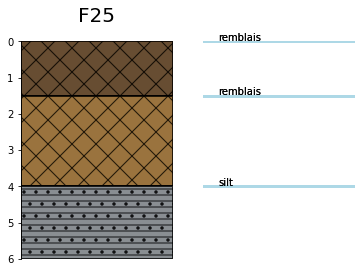

In [34]:
bh.stripBH(title=True)

In [13]:
bh.dfs

{'Boreholes':      id
 0   F10
 1   F11
 2   F12
 3   F13
 4   F14
 5   F15
 6   F16
 7   F20
 8   F21
 9   F22
 10  F23
 11  F24
 12  F25
 13  F10
 14  F11
 15  F12
 16  F13
 17  F14
 18  F15
 19  F16
 20  F20
 21  F21
 22  F22
 23  F23
 24  F24
 25  F25,
 'Components':     borehole  top  base        key     value
 0        F10  0.0   1.5  lithology  remblais
 1        F10  0.0   1.5     colour      ocre
 2        F10  1.5   4.0  lithology  remblais
 3        F10  1.5   4.0     colour      ocre
 4        F10  4.0   6.0  lithology      silt
 ..       ...  ...   ...        ...       ...
 151      F25  0.0   1.5     colour      brun
 152      F25  1.5   4.0  lithology  remblais
 153      F25  1.5   4.0     colour      ocre
 154      F25  4.0   6.0  lithology      silt
 155      F25  4.0   6.0     colour      gris
 
 [156 rows x 5 columns],
 'Intervals':    borehole  top  base           description
 0       F10  0.0   1.5  remblais non-saturés
 1       F10  1.5   4.0      remblais saturés

## Build a geometry by retrieving vertices and segments from intervals 


In [14]:
bh.build_geometry()

In [15]:
bh.geometry.vertices.array

Vector3Array([[0.5, 0.5, 0. ],
              [0.5, 0.5, 1.5],
              [0.5, 0.5, 4. ],
              [0.5, 0.5, 6. ]])

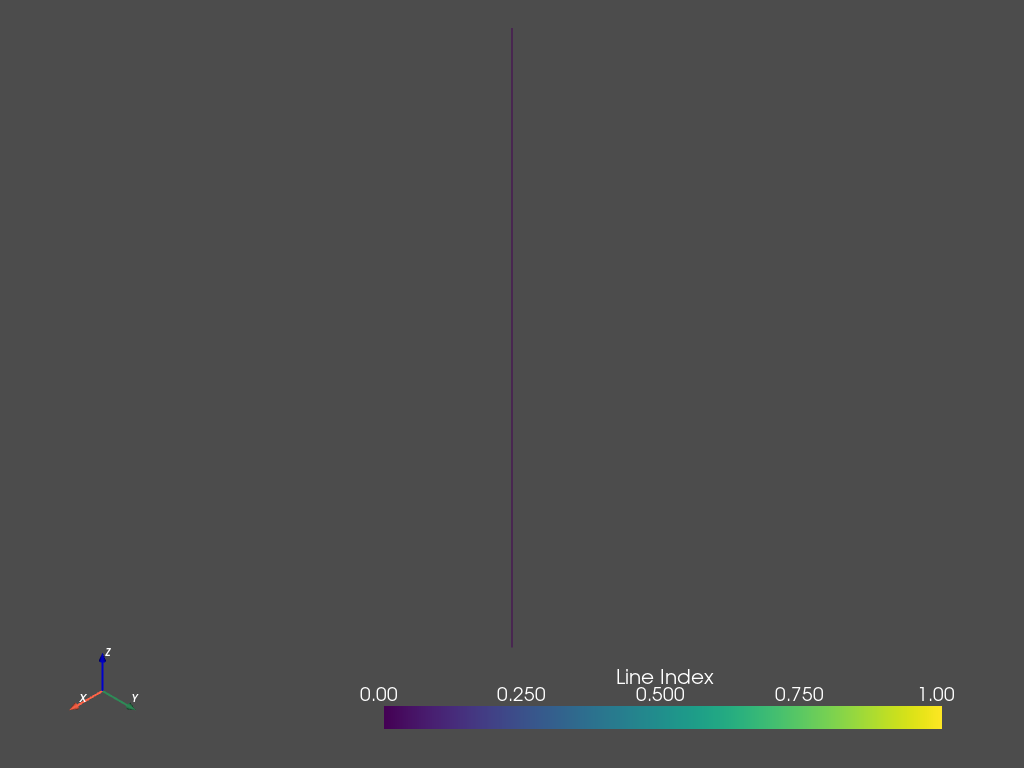

[(7.192130429902464, 7.192130429902464, 9.692130429902464),
 (0.5, 0.5, 3.0),
 (0.0, 0.0, 1.0)]

In [16]:
bh.triDim_plot()

In [10]:
bh.dfs['Components']

,borehole,top,base,key,value
0,F10,0.0,1.5,lithology,remblais
1,F10,0.0,1.5,colour,ocre
2,F10,1.5,4.0,lithology,remblais
3,F10,1.5,4.0,colour,ocre
4,F10,4.0,6.0,lithology,silt
...,...,...,...,...,...
151,F25,0.0,1.5,colour,brun
152,F25,1.5,4.0,lithology,remblais
153,F25,1.5,4.0,colour,ocre
154,F25,4.0,6.0,lithology,silt
